In [3]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, auc
from mlflow.models import infer_signature
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, f1_score



In [4]:
train = pd.read_csv("/content/drive/MyDrive/AML_ASSIGNMENT/ASSIGNMENT 2/train.csv")
val = pd.read_csv("/content/drive/MyDrive/AML_ASSIGNMENT/ASSIGNMENT 2/validation.csv")
test = pd.read_csv("/content/drive/MyDrive/AML_ASSIGNMENT/ASSIGNMENT 2/test.csv")

In [5]:
train = train.dropna(subset=['message'])
val = val.dropna(subset=['message'])
test = test.dropna(subset=['message'])

In [6]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

pipeline.fit(train['message'])

X_train = pipeline.transform(train['message'])
X_val = pipeline.transform(val['message'])
X_test = pipeline.transform(test['message'])

y_train = train['label']
y_val = val['label']
y_test = test['label']

In [7]:
mlflow.set_experiment("Message Classification Models")

2025/03/04 11:36:58 INFO mlflow.tracking.fluent: Experiment with name 'Message Classification Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/308280361396062379', creation_time=1741088218468, experiment_id='308280361396062379', last_update_time=1741088218468, lifecycle_stage='active', name='Message Classification Models', tags={}>

In [8]:
AUC_PR = pd.DataFrame(np.zeros((3, 1)), columns=["AUC-PR"], index=["Naive Bayes", "Logistic Regression", "SVM"])


In [9]:
def train_and_log_model(model, model_name):
    with mlflow.start_run():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Compute Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_pr = auc(recall, precision)

        # Log metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_metrics({
            "AUC-PR": auc_pr,
            "Accuracy": accuracy_score(y_val, y_pred),
            "F1-Score": f1_score(y_val, y_pred)
        })

        # Save model
        signature = infer_signature(X_val, y_val)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="sklearn-model",
            signature=signature,
            registered_model_name=model_name
        )

        # Update AUC-PR scores in DataFrame
        AUC_PR.loc[model_name, "AUC-PR"] = auc_pr

        # Plot Precision-Recall Curve
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve: {model_name}")
        plt.grid()
        plt.show()

Choosing the best three models from Assignment 1

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Naive Bayes'.
Created version '1' of model 'Naive Bayes'.


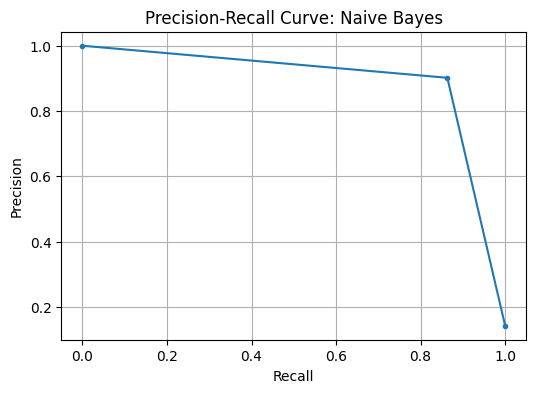

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Logistic Regression'.
Created version '1' of model 'Logistic Regression'.


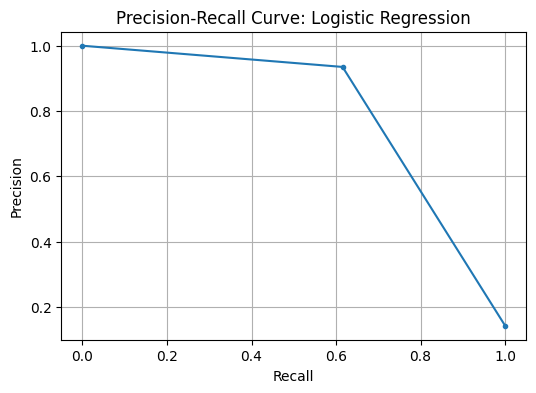

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'SVM'.
Created version '1' of model 'SVM'.


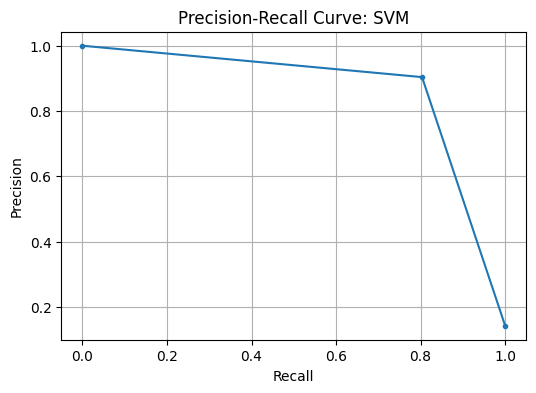

In [10]:
train_and_log_model(MultinomialNB(alpha=0.05), "Naive Bayes")
train_and_log_model(LogisticRegression(max_iter=1000), "Logistic Regression")
train_and_log_model(SVC(kernel="linear", probability=True), "SVM")

In [11]:
AUC_PR

,AUC-PR
Naive Bayes,0.892261
Logistic Regression,0.802630
SVM,0.867640


Naive Bayes has the highest AUC-PR score